### Real Estate Housing Analysis in Bay Area


#### Xiuping Tan 
#### Tsz Chi Leung 


For this project, we used the data extracted from a real estate website called [MLSListings](https://www.mlslistings.com/) get the current housing sales and performed some basic machine learning analysis. 

### Introduction

MLSListings is a premier multiple listing service and authorized trading platform for real estate professionals and the public. Their customers are REALTORS®, brokers and agents throughout northern California. All this information provides a real-time database for real estate professionals to know precisely when a property is available for sale at any given moment and precisely when a property sells and for what price.

Housing in California has been more expensive than most of other states in the United States. Research shows that the median home price in 2016 increased by about 6.2% over the previous year, up to \$500,000. As housing prices are increasing so fast, people might want to buy a home before it gets even higher. One way is to understand what's going on in our local real estate market. Thus, our motivations for this project is to analyze the current housing sales various within Bay Area of California and their predicted values. We choose to work with four major counties in California: Alameda, San Francisco, San Mateo, and Santa Clara counties. 


### Data Extraction

To retrieve data from current housing sales, we performed web scraping using BeautifulSoup. The general idea is to access the information from the web page and convert it to a format that is usable for analysis. In this case, we saved the results to a CSV file that later use as our dataset.

Before doing scraping, we first stored all the urls of results from searching those four counties. For example, if the search results for San Mateo County have 30 pages in total, then we appended the url for each page to the urls array.

In [1]:
import csv
import requests
import requests_cache
from bs4 import BeautifulSoup

# cache file including the data extraction is too big > 100MB
# shared link: https://drive.google.com/file/d/112gRaZRiQWT8WAAga6hQcTCR3vuTm09j/view?usp=sharing
requests_cache.install_cache('finalproject_cache')

urls = []
county = ['San Francisco County', 'San Mateo County', 'Santa Clara County', 'Alameda County']
# MLSlisting website doesn't have a clean search result website. So we did this four searches and copy over.
countyrep = ['db41af32-7fe2-4036-a325-54c3f7a72cd0','ac909bd1-195b-4dfd-977e-6d9e3827c4b4',
             '5eee51dc-8689-4509-9332-a6651c4d56b7','0848292e-0973-47d2-a4d1-01456161b6b5']

for i in countyrep:
    url = 'https://www.mlslistings.com/Search/Result/%s/1?view=list' %i
    res = requests.get(url)
    res = res.text.encode(res.encoding).decode('utf-8')
    soup = BeautifulSoup(res, 'html.parser')
    page = soup.findAll('a', {'class':'page-link last'})
    total_pages = int(page[0].get('href').split('/')[-1].split('?')[0]) #total number of pages
    # generates urls of all pages
    for j in list(range(1,total_pages+1)):
        pair = []
        pair.append('https://www.mlslistings.com/Search/Result/%s/%s?view=list' %(i,j))
        pair.append(county[countyrep.index(i)])
        urls.append(pair)


Once we get the urls of all the pages, we will scrape data for all the house listings in those pages. The variables that we can extract from search results are the address, the zip code, what county it belongs to, the listing price, housing type, number of bedrooms, number of bathrooms, housing size, lot size if it has one, garage, and the year built.


In [2]:
# Create a csv file that saves our data
f = open('dataset.csv', 'w', newline='')
file = csv.writer(f)
file.writerow(['address','zipcode','county','price','housing_type','beds','baths','sqfts','lotsize','garage','yearbuilt'])

for url in urls:
    res = requests.get(url[0])
    res = res.text.encode(res.encoding).decode('utf-8')
    soup = BeautifulSoup(res, 'html.parser')
    onepage = soup.find_all('div', {'class': 'card card-block pt-1 pb-1 px-1'})
    # extract all the information variables we need in the url
    for i in list(range(len(onepage))):
        address,price,h_type,h_bed,h_bath,h_sqft,h_lot,h_garage,h_yearbuilt = ["" for _ in range(9)]
        address = onepage[i].find_all('a', {'class':'search-nav-link'})[0].text
        zipcode = address[-5:]
        price = onepage[i].find_all('span', {'class':'font-weight-bold listing-price d-block pull-left pr-25'})[0].text
        h_type = onepage[i].find_all('div', {'class':'listing-info clearfix font-size-sm line-height-base listing-type mb-25'})[0].text
        h_type = " ".join(h_type.split())
        tag = 'listing-info-item font-size-sm line-height-base d-block pull-left pr-50 '
        beds = onepage[i].find_all('span', {'class':tag+'listing-beds'})
        if(len(beds)): h_bed = beds[0].find_all('span')[0].text
        baths = onepage[i].find_all('span', {'class':tag+'listing-baths'})
        if(len(baths)): h_bath = baths[0].find_all('span')[0].text
        sqfts = onepage[i].find_all('span', {'class':tag+'listing-sqft last'})
        if(len(sqfts)): 
            h_sqft = sqfts[0].find_all('span')[0].text
        if(len(sqfts) > 0):    
            h_yearbuilt = sqfts[1].find_all('span')[0].text
        lot = onepage[i].find_all('span', {'class':tag+'listing-lot-size'})
        if(len(lot)): h_lot = lot[0].find_all('span')[0].text
        garage = onepage[i].find_all('span', {'class':tag+'listing-garage'})
        if(len(garage)): h_garage = garage[0].find_all('span')[0].text
        # write to the csv
        file.writerow([address,zipcode,url[1],price,h_type,h_bed,h_bath,h_sqft,h_lot,h_garage,h_yearbuilt])
        
f.close()


### Data Preprocessing

As you can see from the table above, there are some aspects of the data that would be hard for doing calculations or analysis. In particularly, price is an important variable that we will use but Python doesn't know how to handle values with commas and dollar signs. Thus, we need to perform several data preprocessing tasks.
- Cleaning the missing values  
- Convert string values to numerical values that allows calculations 
- Remove duplicates 

In [28]:
# Loading the dataset
import pandas as pd
import numpy as np

housing = pd.read_csv('./dataset.csv', encoding="windows-1256")
housing.head()

,address,zipcode,county,price,housing_type,beds,baths,sqfts,lotsize,garage,yearbuilt
0,"388 Townsend St 5, San Francisco, CA 94107",94107,San Francisco County,"$1,049,000",Condominium,1.0,2,"1,055","10,856",1,1999
1,"2225 23rd St 404, San Francisco, CA 94107",94107,San Francisco County,"$549,000",Condominium,1.0,1,602,1.841,1,1989
2,"3345 17th St, San Francisco, CA 94110",94110,San Francisco County,"$1,099,000",Condominium,1.0,1/1,"1,311","4,891",1,2002
3,"555 4th St 639, San Francisco, CA 94107",94107,San Francisco County,"$849,000",Condominium,1.0,1,752,1.451,1,2006
4,"82 Staples Ave, San Francisco, CA 94131",94131,San Francisco County,"$1,249,000",Single Family Residence,3.0,3,"1,753","2,500",1,1946


In [29]:
# Filter out any rows with NA for these columns
df = housing
housing = df[df['beds'].notnull() & df['baths'].notnull()  & df['sqfts'].notnull() 
   & df['lotsize'].notnull() & df['garage'].notnull() & df['yearbuilt'].notnull()].reset_index(drop = True)
housing = housing[housing.yearbuilt != '–'].reset_index(drop = True)

# format correct zip code
housing.zipcode = housing.address.apply(lambda x: x.split('CA')).reset_index(drop = True)
housing = housing[housing.zipcode.apply(lambda x: len(x) > 1)] #zipcode exists
housing.zipcode = housing.zipcode.apply(lambda x: x[1][:6])

# format price (remove dollar sign)
housing.price = housing.price.apply(lambda x: int(x[1:].replace(',' , '')))

# format sqfts, lotsize (convert between acres to sqft) , garage
housing.sqfts = housing.sqfts.replace('–', 0)
housing.sqfts = housing.sqfts.apply(lambda x: str(x).replace(',' , ''))
housing.lotsize = housing.lotsize.replace('–', 0)
housing.lotsize = housing.lotsize.apply(lambda x: str(x).replace(',' , ''))

def acres(lotsize):
    """Convert lotsize from acres to sqft. We recognized that lotsize are integers so if it contain . (float), 
    then it is stored as acres instead of sqft, so we need to convert it to sqft.
    
    Args:
        lotsize (string) : by default we extracted from url lotsize is stored as string
    Returns:
        lotsize: housing lotsize in sqft
    """
    if("." in lotsize):
        lotsize = float(lotsize)*43560 
    return lotsize

housing.lotsize = housing.lotsize.apply(acres)
housing.garage = housing.garage.replace('–', 0)

# format baths
def convert_baths(baths_str):
    """Convert extracted bathrooms to numerical that enables future analysis. For example 2/1 bathrooms will 
    convert to 2.5 bathrooms  
    
    Args:
        baths_str (string) : extracted bathroom info
    Returns:
        bath_num (float) : numerical bathrooms
    """
    arr = baths_str.split('/')
    if(len(arr) > 1):
        bath_num = int(arr[0]) + int(arr[1])*0.5
    else:
        bath_num = baths_str
    return float(bath_num)

# drop duplicates
housing = housing.drop_duplicates()

# convert to appropriate data types
housing.zipcode = housing.zipcode.astype(int)
housing.beds = housing.beds.astype(int)
housing.baths = housing.baths.apply(convert_baths)
housing.sqfts = housing.sqfts.astype(int)
housing.lotsize = housing.lotsize.astype(int)
housing.garage = housing.garage.astype(int)
housing.yearbuilt = housing.yearbuilt.astype(int)


### Exploratory data analysis

First step in analyzing data is by EDA:
- Explore structures of the data
- Makes use of simple descriptive statistics
- Extract or generate important variables
- Finding errors and outliers
- Correlations between variables


In [30]:
print(housing.shape)
housing.dtypes

(5320, 11)


address          object
zipcode           int64
county           object
price             int64
housing_type     object
beds              int64
baths           float64
sqfts             int64
lotsize           int64
garage            int64
yearbuilt         int64
dtype: object

In [31]:
# calcualte the price per sqft
housing['price_per_sqft'] = housing.price / housing.sqfts

housing.describe()

,zipcode,price,beds,baths,sqfts,lotsize,garage,yearbuilt,price_per_sqft
count,5320.000000,5.320000e+03,5320.000000,5320.000000,5320.000000,5.320000e+03,5320.000000,5320.000000,5320.000000
mean,94625.038722,1.421253e+06,3.241917,2.410714,1985.417293,2.627917e+04,1.669173,1971.728759,inf
std,1293.522793,1.867281e+06,1.162785,1.138764,1386.458643,1.432234e+05,1.039341,29.477309,NaN
min,4546.000000,3.000000e+04,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1854.000000,26.041667
25%,94501.000000,6.899800e+05,2.000000,2.000000,1200.000000,2.599750e+03,1.000000,1954.000000,463.702866
50%,94587.000000,9.597450e+05,3.000000,2.000000,1596.000000,5.850000e+03,2.000000,1972.000000,597.115118
75%,95037.000000,1.485750e+06,4.000000,3.000000,2258.000000,8.627500e+03,2.000000,1996.000000,810.023425
max,97603.000000,3.950000e+07,12.000000,13.500000,17742.000000,5.257692e+06,25.000000,2018.000000,inf


We see some infinite values and missings in price_per_sqft. The reason might be that the website doesn't have housing size reported but we can't divide the price by zero. Therefore, the only way is to remove those housing size not reported. Also, we noticed that the minimum values for zipcode is 4546 which is not a valid postal code for California. We assume that it should be changed to 94546. 

In [32]:
# remove those housing size not reported
housing = housing[housing.price_per_sqft != float('Inf')]
housing.loc[housing['zipcode'] == 4546, 'zipcode'] = 94546
housing = housing[housing.price > 1]

housing.describe()

,zipcode,price,beds,baths,sqfts,lotsize,garage,yearbuilt,price_per_sqft
count,5310.000000,5.310000e+03,5310.000000,5310.00000,5310.000000,5.310000e+03,5310.000000,5310.000000,5310.000000
mean,94642.508851,1.421706e+06,3.242750,2.41177,1989.156309,2.632162e+04,1.670245,1971.766855,682.404393
std,383.904636,1.868258e+06,1.163106,1.13825,1385.081027,1.433548e+05,1.039582,29.425744,405.238888
min,92588.000000,3.000000e+04,0.000000,0.00000,355.000000,0.000000e+00,0.000000,1854.000000,26.041667
25%,94501.000000,6.899990e+05,2.000000,2.00000,1200.000000,2.623500e+03,1.000000,1954.000000,463.590060
50%,94587.000000,9.599995e+05,3.000000,2.00000,1598.000000,5.850000e+03,2.000000,1972.000000,596.782975
75%,95037.000000,1.487250e+06,4.000000,3.00000,2261.500000,8.638750e+03,2.000000,1996.000000,808.879611
max,97603.000000,3.950000e+07,12.000000,13.50000,17742.000000,5.257692e+06,25.000000,2018.000000,10909.090909


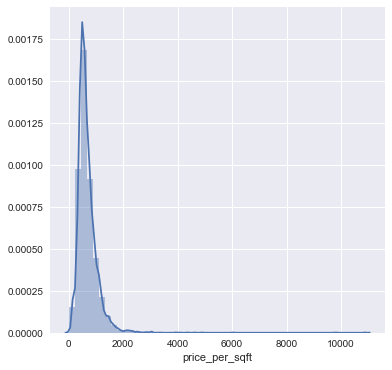

In [33]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd         
import osmnx as ox              
import shapely.geometry as geom 

# histogram
plt.figure(figsize=(6,6))
sns.distplot(housing['price_per_sqft'])

The plot above is the distribution of price per sqft, which we are interested to see if there are outliers in price or housing size. This is a right-skewed distribution with a long right tail. We observed that values with price per sqft above 2000 might be possible outliers, but we want to further examine the price and sqfts. 

Text(0.5,1,'Check for Outliers')

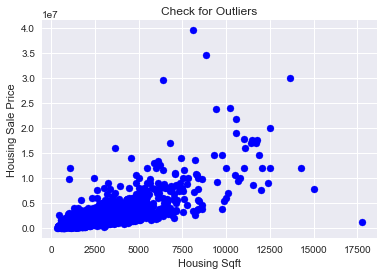

In [34]:
# check outliers
plt.scatter(housing.sqfts,housing.price, c='blue')
plt.xlabel('Housing Sqft')
plt.ylabel('Housing Sale Price')
plt.title('Check for Outliers')

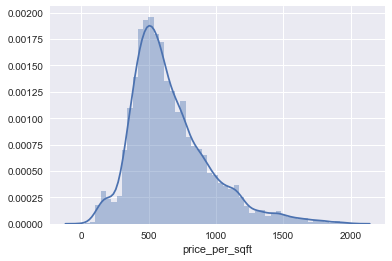

In [35]:
# remove the outliers
housing = housing[housing.sqfts < 13000]
housing = housing[housing.price_per_sqft < 2000]

# histogram
sns.distplot(housing['price_per_sqft'])

In the scatter plot for checking outliers, we see a few points with very high housing size in sqfts (above 13000 sqfts) but with very low price. Those are considered as outliers because usually we won't have such a huge house with low price. The same applies to the price per sqft. Now, the distribution looks much better after removing outliers.

In [36]:
# Number of house listings in each county
housing.groupby('county').agg({'address': 'count'})

,address
county,
Alameda County,2154
San Francisco County,91
San Mateo County,835
Santa Clara County,2177


In [37]:
# Median House Prices by zipcode
med_houseprice_zipcode = housing.groupby('zipcode').agg({'price_per_sqft': 'median'})
med_houseprice_zipcode.drop_duplicates()
med_houseprice_zipcode['zipcode'] = med_houseprice_zipcode.index.astype(int)
med_houseprice_zipcode.sort_values(by='price_per_sqft',ascending=False).head()

,price_per_sqft,zipcode
zipcode,,
94301,1474.377135,94301
94027,1363.002016,94027
94108,1360.074627,94108
94306,1338.278108,94306
94022,1322.313777,94022


We see that San Francisco and San Mateo counties have less numbers of housing for sale; thus, we will investigate cities within the county instead. However, our dataset only have postal codes information but not cities. We found an [online dataset](https://www.gaslampmedia.com/download-zip-code-latitude-longitude-city-state-county-csv/) that was compiled from a city/county/state database and geocoded with Google Maps. Using this, we can merge with the our data and get city information.

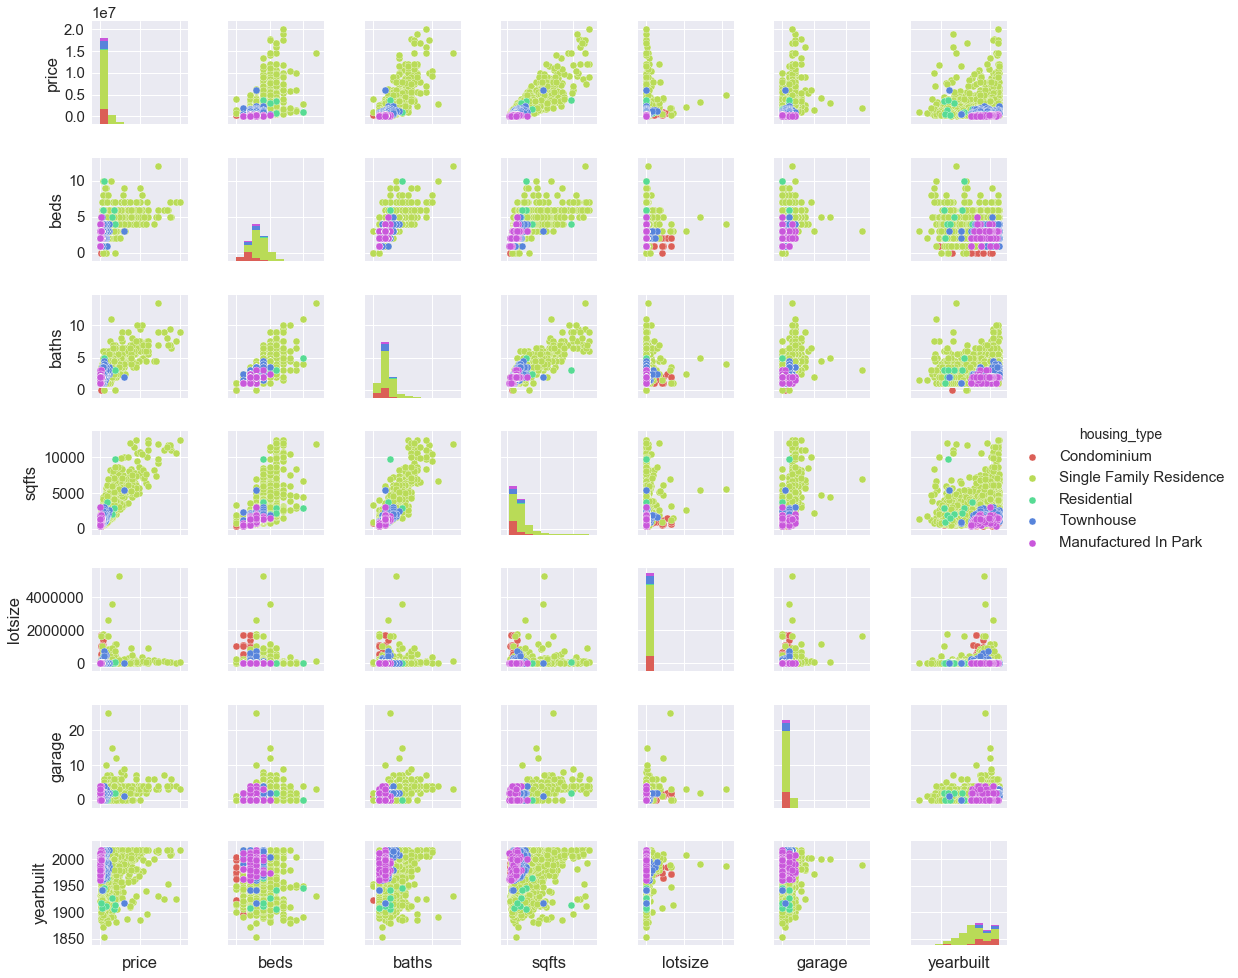

In [38]:
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats

# Pair plot to explore variables
with sns.plotting_context("notebook",font_scale=1.5):
    g = sns.pairplot(housing, vars = ['price', 'beds','baths','sqfts','lotsize','garage','yearbuilt'], 
                 hue='housing_type',palette= sns.hls_palette(5),size=2)
g.set(xticklabels=[]);

Analysis: 
    <ol>
        <li>Spot an outlier for garage, and a few outliers for lotsize. </li>
        <li>Observed a positive linear relationship between price and sqfts, price and baths, price and beds.</li>
        <li>Observed that majority of our data is made up of single family residence.</li>
        <li>Lot size and garage seemse to be uncorrelated to price.</li>
    </ol>

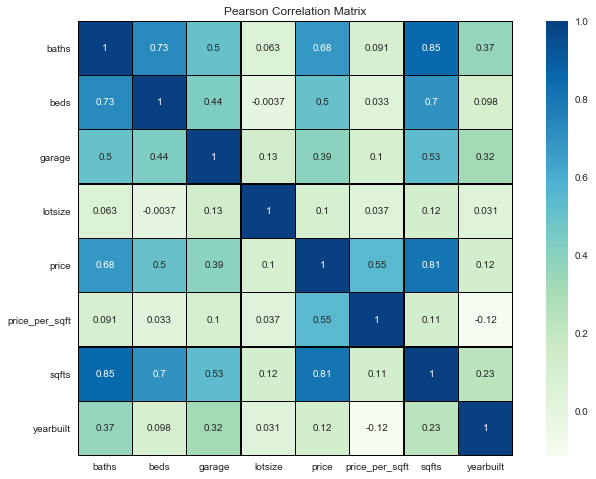

In [39]:
# seaborn correlation matrix
housing.zipcode = housing.zipcode.astype(str)

str_list = []
for colname, colvalue in housing.iteritems():
    if type(colvalue[1]) == str:
         str_list.append(colname)
            
# Only compare numerical features          
diff_list = housing.columns.difference(str_list) 
house = housing[diff_list]
f, ax = plt.subplots(figsize=(12, 8))
plt.title('Pearson Correlation Matrix')

sns.heatmap(house.astype(float).corr(),linewidths=0.25,vmax=1.0, square=True, cmap="GnBu", linecolor='k', annot=True)
plt.show()

__Analysis:__ As we can see from the above correlation matrix, price is strongly correlated to sqfts, baths, then beds.


### Which city is the most expensive? Which is the least expensive?

In [40]:
# Get city name from another dataset matching 
zipcodes = pd.read_csv('./zip_codes_ca.csv')
zipcodes.zipcode = zipcodes.zipcode.astype(int)
zipcodes.head()

# Merge it with zipcodes to get city name
zip_avg = pd.merge(zipcodes, med_houseprice_zipcode, on='zipcode')
city_avg = zip_avg[['city', 'price_per_sqft']]

# Group by city, and take average of price/sqft between zipcodes
city_avg = city_avg.groupby('city').agg({'price_per_sqft': 'mean'})
city_avg['city'] = [s.upper() for s in city_avg.index.astype(str)]
city_avg.sort_values(by='price_per_sqft',ascending=False).head()

,price_per_sqft,city
city,,
Atherton,1363.002016,ATHERTON
Los Altos,1251.885357,LOS ALTOS
Palo Alto,1226.420505,PALO ALTO
Portola Valley,1211.768710,PORTOLA VALLEY
Menlo Park,1195.422535,MENLO PARK


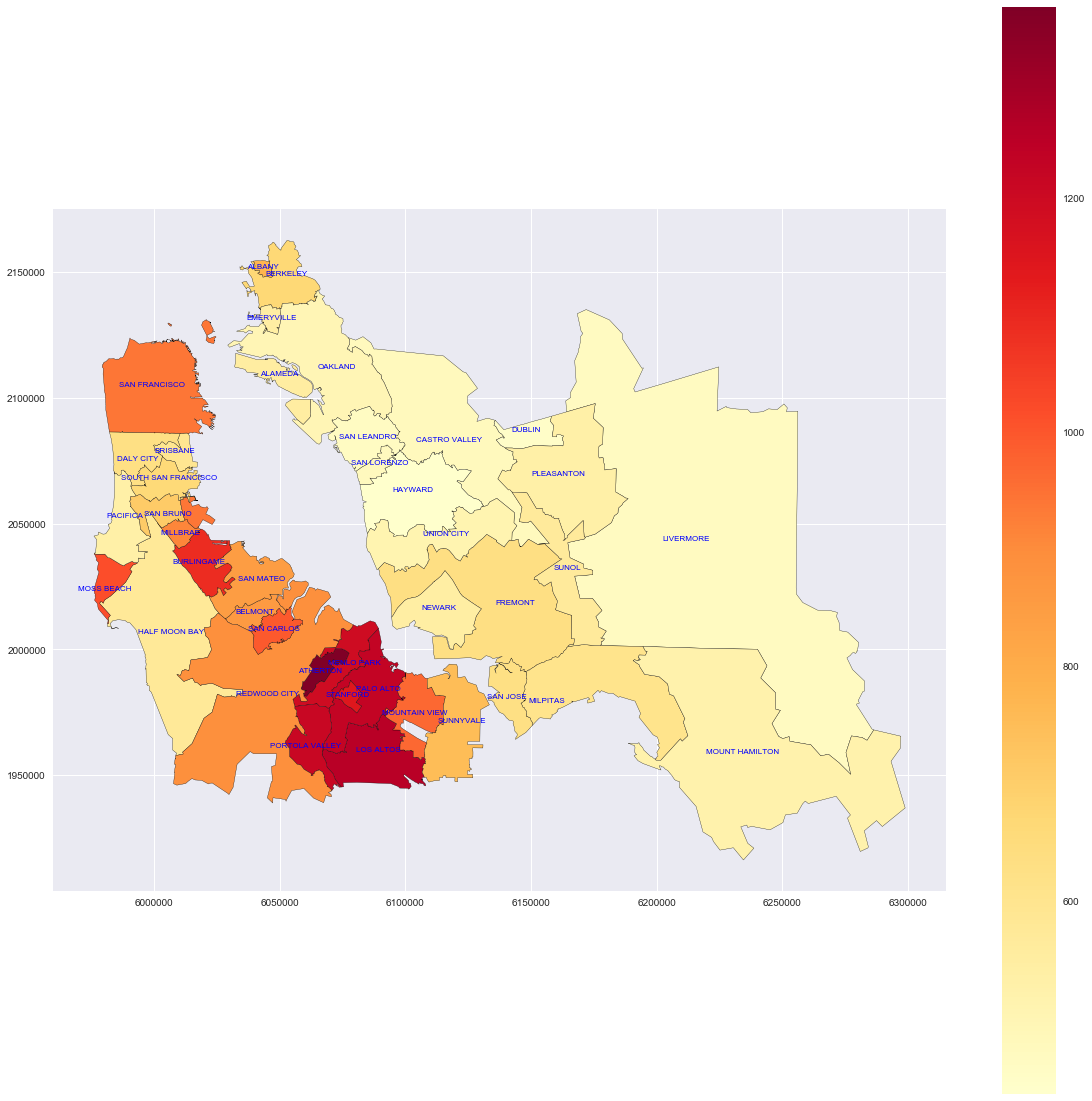

In [41]:
counties = gpd.read_file("shapefiles/cb_2016_us_zcta510_500k.shp")
counties.rename(columns={'GEOID10':'zipcode'}, inplace=True)
counties = counties[['zipcode','geometry']]
# in order to merge on zipcode
counties.zipcode = counties.zipcode.astype(int)

# read in bay shp
bay = gpd.read_file("./shapefiles/bayarea_zipcodes.shp")
bay = bay [['PO_NAME', 'geometry']]

# dissolve the city polygons into one polygon per city
bay = bay.dissolve(by = 'PO_NAME')
bay['city'] = bay.index.astype(str)

# merge it with bay to get polygon
Geo_City = pd.merge(city_avg, bay, on = 'city', how = 'inner')
Geo_City = gpd.GeoDataFrame(Geo_City)

# plot the price/sqft heatmap
ax = Geo_City.plot(column = 'price_per_sqft',cmap='YlOrRd', legend = True, edgecolor = "black", figsize = (20,20))

#add label to each polyong(city)
def add_label(row):
    coords = row.geometry.representative_point().coords[0]
    ax.annotate(row['city'], xy = coords, horizontalalignment = "center", color = 'blue', fontsize=8)
Geo_City.apply(add_label, axis= 1)

plt.show()

__Analysis:__ We see the southern end of the San Francisco Bay locates a lot of cities with high housing sale prices, including the cities of Palo Alto, Stanford and Los Altos. That is the Santa Clara County, also referred to as "Silicon Valley". Alameda County is occupying much of the East Bay region including Oakland, San Leandro, and Hayward that have much lower housing sale prices. 

### Is there a different distribution of price/sqft over different type of housing?

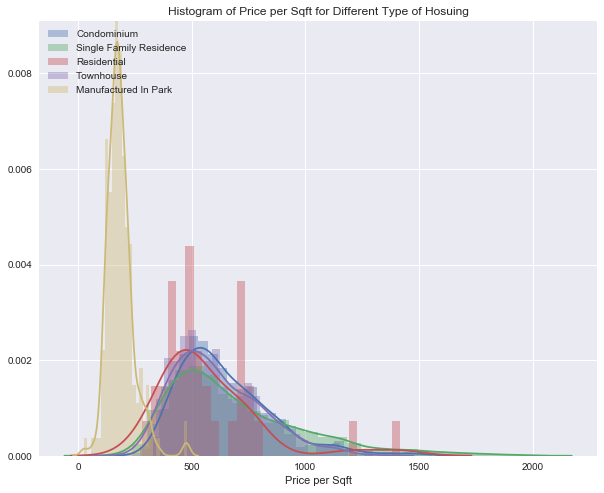

In [42]:
#histogram of price based on different housing types
housing_type = housing.housing_type.unique()

plt.subplots(figsize=(10,8))
for t in np.ndenumerate(housing_type):
    kind = housing[housing['housing_type'] == t[1]]
    sns.distplot(kind.price_per_sqft, label=t[1],bins=30, norm_hist = True)
    
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.legend(loc=2)
plt.title('Histogram of Price per Sqft for Different Type of Hosuing')
plt.xlabel('Price per Sqft')
plt.show()

__Analysis:__ The histogram shows __positive skewness__, we can adjust it by __log transformation, and normalized the distribution.__

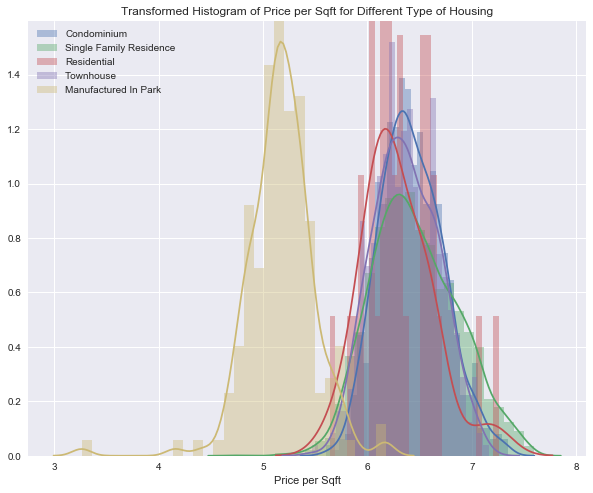

In [43]:
# Log transformation of price/sqft for different type of housing
housing['log_price_sqft'] = np.log(housing['price_per_sqft'])

plt.subplots(figsize=(10,8))
for t in np.ndenumerate(housing_type):
    kind = housing[housing['housing_type'] == t[1]]
    sns.distplot(kind.log_price_sqft, label=t[1],bins=30, norm_hist = True)
    
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.legend(loc=2)
plt.title('Transformed Histogram of Price per Sqft for Different Type of Housing')
plt.xlabel('Price per Sqft')
plt.show()

__Analysis:__ After log transformation, the graph shows that the Manufactured in Park, i.e. mobile housing is significantly cheaper than the other housing, and the other housing appears to have a negative skewness after adjustment.

### How are the floor plans of housing various between cities in Alameda County?

In [44]:
#merge it with zipcodes to get city name
zipcodes.zipcode = zipcodes.zipcode.astype(str)
alameda = housing[housing.county == "Alameda County"]
alameda = pd.merge(zipcodes, alameda, on='zipcode')
alameda = alameda[['city', 'county_x', 'baths', 'beds']]
alameda = alameda[alameda.county_x == "Alameda"]

# form the floor_plan groups 
floor_plan = alameda.groupby(['baths', 'beds', 'city']).agg({'county_x':'count'})
floor_plan = floor_plan.reset_index()
floor_plan.rename(columns = {"county_x": "Counts"}, inplace = True)

# we need the beds and baths to be strings in order to create the floor plan
# but since since baths are float, we convert to int first
floor_plan.beds = floor_plan.beds.astype(str)
floor_plan.baths = floor_plan.baths.astype(int)
floor_plan.baths = floor_plan.baths.astype(str)

floor_plan['floor'] = floor_plan.beds + " be " + floor_plan.baths + " ba"
floor_plan.sort_values(by='Counts', ascending=False).reset_index(drop=True).head()

,baths,beds,city,Counts,floor
0,1,2,Oakland,103,2 be 1 ba
1,2,3,Oakland,85,3 be 2 ba
2,2,3,Fremont,57,3 be 2 ba
3,2,3,Livermore,56,3 be 2 ba
4,2,2,Oakland,53,2 be 2 ba


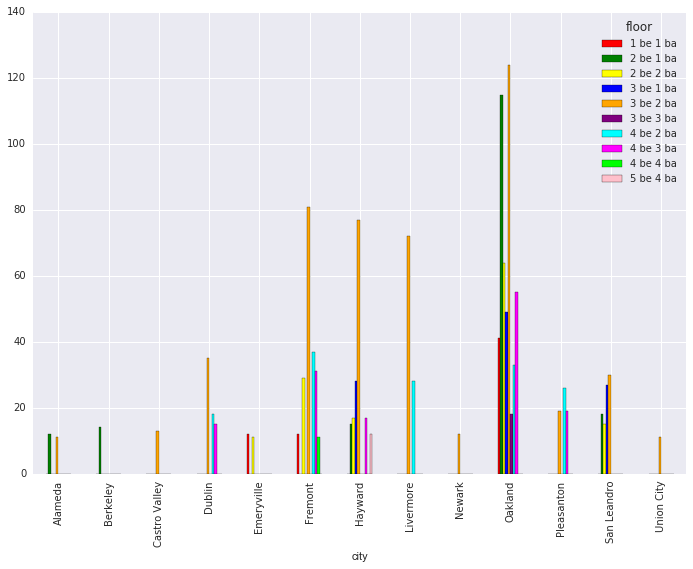

In [18]:
# Since there are too many floor plans, keep only ones that more than 10
floor_plan = floor_plan[floor_plan.Counts > 10]

# plot the grouped bar graphs
floor_plan_bar = floor_plan.groupby(['city','floor'])['Counts'].sum()
floor_plan_bar = floor_plan_bar.reset_index()
floor_plan_bar.groupby(['city','floor']).sum()['Counts'] \
    .unstack().plot(kind="bar", color=['red','green','yellow','blue','orange','purple','cyan','magenta','lime','pink','teal'])

Since previously we've showed that Alameda County has low housing sale prices out of the four counties, we would like to know how different floor plans are various between cities in the Alameda County. In the plot, we filtered out the floor plan that have more than 10 in a city, which considered as what floor plans that city mostly have. 

The common floor plans between cities are 2 bedrooms 1 bathroom (green) and 3 bedrooms 2 bathrooms (orange). However, some cities have quite limited floor plans such as Berkeley, Newark, and Emeryville. We see that Oakland, Fremont, and Hayward have various floor plan options. 

Let's say if someone have a big family and look for a big house with 4 bedrooms 4 bathrooms. Based on this, we can recommend looking for houses in Fremont. Interestingly, we also found that Dublin have mostly more bedrooms such as 3 or 4 but not 2.

## Machine Learning
We will use machine learning regression models to estimate the other houses listing price in the market; and predict the new houses coming on the market based on the current listing data we have.

__Regression Models used for current listings are :__
<ul>
    <li>Simple Linear Regression</li>
    <li>Multiple Linear Regression</li>

</ul>
__Regression Models used for future listings are :__
<ul>
    <li>Decision Tree Regressor</li>
    <li>Random Forest Regressor</li>
</ul>
We will use Root Mean Squared Error (RMSE) on the test data to evaluate their performance.

In [45]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error 
from sklearn import preprocessing

First, we split the data into training and testing data on a 80-20% ratio

In [57]:
from sklearn.cross_validation import train_test_split
train_data, test_data = train_test_split(housing, train_size = 0.8, random_state = 10)

## 1.Simple Linear Regression

In [58]:
def simple_linear(train, test, feature):
    """simple linear regression function specified for the use of our dataset 
    Args:
        train(dataframe): training dataset
        test(dataframe): testing dataset
        feature(Series): features in a dataset
    Returns:
        RMSE(float): Root Mean Squared Error
        regr.intercept (float): regression interception
        regr.coefficient (float): regression coefficient
    """
    regr = linear_model.LinearRegression()
    #Train the model
    regr.fit(train.as_matrix(columns = [feature]), train.as_matrix(columns = ['price']))
    # Calculate the RMSE on test data
    RMSE = mean_squared_error(test.as_matrix(columns = ['price']), 
                              regr.predict(test.as_matrix(columns = [feature])))**0.5 
    return RMSE, regr.intercept_[0], regr.coef_[0][0]

#create an input list, remove the variables we are predicting and non-numerical data
input_list = train_data.columns.values.tolist()
input_list.remove('price') 
input_list.remove('address') 
input_list.remove('housing_type')
input_list.remove('county')

simple_linear_result = pd.DataFrame(columns = ['feature', 'RMSE', 'intercept', 'coefficient'])

# Calculate the RMSE of the test data for each feature
for p in input_list:
    RMSE, w1, w0 = simple_linear(train_data, test_data, p)
    simple_linear_result = simple_linear_result.append({'feature':p, 'RMSE':RMSE, 'intercept':w0, 'coefficient': w1}
                                                        ,ignore_index=True)
simple_linear_result

,feature,RMSE,intercept,coefficient
0,zipcode,1.434532e+06,-6.869082e+02,6.636046e+07
1,beds,1.283808e+06,6.217147e+05,-6.717591e+05
2,baths,1.084087e+06,8.763602e+05,-7.708000e+05
3,sqfts,8.118312e+05,8.875881e+02,-4.048557e+05
4,lotsize,1.465099e+06,1.161545e+00,1.316834e+06
5,garage,1.332420e+06,5.299782e+05,4.525255e+05
6,yearbuilt,1.446031e+06,5.208283e+03,-8.925623e+06
7,price_per_sqft,1.230565e+06,2.687992e+03,-4.306687e+05
8,log_price_sqft,1.295036e+06,1.531628e+06,-8.450661e+06


__Analysis:__ When we employ linear regression, sqfts provides the smallest test error estimate of housing price for our data, with RMSE = 8.118312e+05.

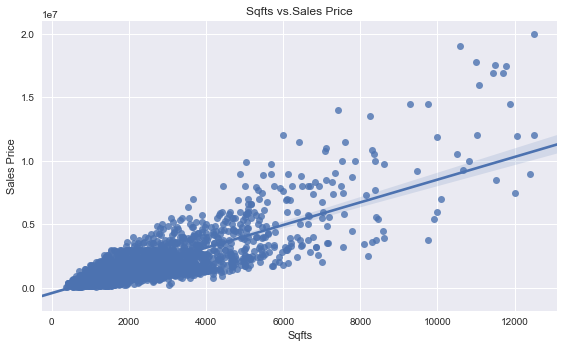

In [48]:
#plot scatterplot of Sqfts vs Sales Price
plt.figure(figsize=(8, 5))
ax = sns.regplot(x = housing.sqfts, y = housing.price)
plt.title('Sqfts vs.Sales Price')
plt.xlabel('Sqfts')
plt.ylabel('Sales Price')

plt.tight_layout()

__Analysis:__ In general, we can see as sqfts increases, the sales prices increases. However, starting from 5000 sqfts on, we observe a less densed cluster, which indicates there are less instances in our data, and also a weakening correlation between sqfts and sales price.

## 2. Multiple Regression
Problems we counter:
<ol>
<li> We don't know how many features to include in the regression, in genereal sense, more features will yield a lower RMSE, but we will face the problem of overfitting the training set, and result in higher error in testing set.</li>
<li> We don't know which feature to include would yield the minimum RMSE on the test set.</li>
</ol>

To solve these problems, we employ a greedy technique called forward stepwise algorithm:
<ol>
    <li>First we choose the best single estimator (ie.sqft in our case);</li>
<li> at each step we test all the remaining features one by one in combinations with the best estimator, and select the feature that yield the lowest training error in the combination; </li>
<li> at the end, we select the model complexity (number of features) using the validation error and estimate the generalization error using the test set.</li>

In [49]:
# further split the train_data to include a validation set
#train_data2 = 60%, validation_data = 20%, test_data = 20%
train_data_2, validation_data = train_test_split(train_data, train_size = 0.75, random_state = 50)

In [50]:
def RMSE(train, validation, features, new_input):
    """RMSE specified for the return RMSE of features
    Args:
        train(dataframe): training dataset
        validation(dataframe): validation dataset
        feature(Series): features in a dataset
        new_input (feature): reminding feature in the dataset
    Returns:
        RMSE(float): Root Mean Squared Error of train data
        RMSE(float): Root Mean Squared Error of validation data
    """
    features_list = list(features)
    features_list.append(new_input)
    regr = linear_model.LinearRegression() 
    regr.fit(train.as_matrix(columns = features_list), train.as_matrix(columns = ['price'])) # Train the model
    RMSE_train = mean_squared_error(train.as_matrix(columns = ['price']), 
                              regr.predict(train.as_matrix(columns = features_list)))**0.5 # Calculate the RMSE on train data
    RMSE_validation = mean_squared_error(validation.as_matrix(columns = ['price']), 
                              regr.predict(validation.as_matrix(columns = features_list)))**0.5 # Calculate the RMSE on train data
    return RMSE_train, RMSE_validation 

In [51]:
input_list = train_data_2.columns.values.tolist() 
#remove the ones that are non-numerical
input_list.remove('price')
input_list.remove('price_per_sqft')
input_list.remove('log_price_sqft')
input_list.remove('address') 
input_list.remove('housing_type')
input_list.remove('county')


greedy_algorithm = pd.DataFrame(columns = ['feature', 'train_error', 'validation_error'])  
i = 0
temp_list = []


# Go through all the features in the dataframe
while len(input_list)>0:
    
    # temporarily store the best feature at each iteration
    temp = pd.DataFrame(columns = ['feature', 'train_error', 'validation_error'])
    
    # to test all the remaining features
    for p in input_list:
        RMSE_train, RMSE_validation = RMSE(train_data_2, validation_data, temp_list, p)
        temp = temp.append({'feature':p, 'train_error':RMSE_train, 'validation_error':RMSE_validation}, ignore_index=True)
    
    # select the best feature with smallest train error
    temp = temp.sort_values('train_error')
    best = temp.iloc[0,0]
    temp_list.append(best)
    greedy_algorithm = greedy_algorithm.append({'feature': best, 
                                                  'train_error': temp.iloc[0,1], 'validation_error': temp.iloc[0,2]}, 
                                                 ignore_index=True)
    #remove the best feature before next iteration
    input_list.remove(best)
    i += 1
greedy_algorithm

,feature,train_error,validation_error
0,sqfts,840000.907055,888016.431279
1,zipcode,816023.102034,854965.876057
2,beds,809173.694392,851401.165189
3,yearbuilt,805904.066128,837840.395584
4,baths,804915.245978,830162.773869
5,garage,804798.586537,832092.961347
6,lotsize,804727.942419,833584.635981


__Analysis:__ 
We can see the validation error reaches minimum when we reach __5__ features in the model and it startes increasing again after the 6th features. 
Therefore, the best number of features to include is 5 to avoid overfitting, and the combination is:
__[Sqft, zipcode, beds, yearbuilt, baths].__

And the error using this combination is:

In [52]:
def multiple_regression_model(train, test, input_features):
    """modifided version of simple linear regression function to take mutliple features
    Args:
        train(dataframe): training dataset
        test(dataframe): testing dataset
        input_feature(Series): features in a dataset
    Returns:
        RMSE(float): Root Mean Squared Error
        regr.intercept (float): regression interception
        regr.coefficient (float): regression coefficient
    """
    regr = linear_model.LinearRegression() # Create a linear regression object
    regr.fit(train.as_matrix(columns = input_features), train.as_matrix(columns = ['price'])) # Train the model
    RMSE = mean_squared_error(test.as_matrix(columns = ['price']), 
                              regr.predict(test.as_matrix(columns = input_features)))**0.5 # Calculate the RMSE on test data
    return RMSE, regr.intercept_[0], regr.coef_ 

In [53]:
greedy_algo_features_list = greedy_algorithm['feature'].tolist()[:4]
test_error, _, _ = multiple_regression_model(train_data_2, test_data, greedy_algo_features_list)
print ('test error (RMSE) is: %s' %test_error)

test error (RMSE) is: 760986.8127670394


And the error using this combination __[Sqft, zipcode, beds, yearbuilt, baths]__ is: 760986.813, which is much lower than the Simple Linear Regression.

## Decision Tree Regressor
We would want to make predictions for new houses coming on the market based on the current listing data we have, and Decision Tree Regressor can achieve that.

In [54]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
y = housing.price
predictors = ['sqfts', 'beds', 'zipcode','yearbuilt', 'baths', 'garage', 'lotsize']
X = housing[predictors]
# split data into training and validation set, for both predictors and target
train_X, val_X, train_y, val_y = train_test_split(X, y,random_state = 5)

Decision Tree Regressor error 
 Training error:  337.6527143581938  
 Validation error:  333550.9539923954


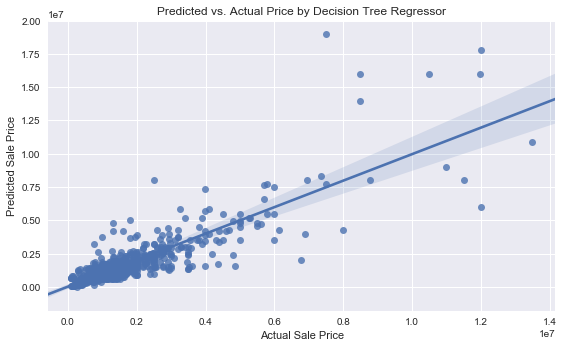

In [55]:
from sklearn.tree import DecisionTreeRegressor

#define model and fit for DecisionTreeRegressor
decision_tree = DecisionTreeRegressor()
decision_tree.fit(train_X, train_y)

#training error
dt_pred = decision_tree.predict(train_X)
dt_training_err = mean_absolute_error(train_y, dt_pred)

# validation error, and its prediction price
val_predictions = decision_tree.predict(val_X)
dt_val_err = mean_absolute_error(val_y, val_predictions)

print("Decision Tree Regressor error \n", 
      "Training error: ", dt_training_err,  " \n",
      "Validation error: ", dt_val_err)

plt.figure(figsize=(8, 5))
ax = sns.regplot(x = val_y, y = val_predictions)
plt.title('Predicted vs. Actual Price by Decision Tree Regressor')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

plt.tight_layout()

__Analysis of Error:__ <br> As we can see the Training Error is very low compared to the Validation Error, it indicates that the Decision Tree is overfitting.<br><br>
__Analysis of Regression Plot:__<br>
We can see that most of the price predictions below \$2.5 millions are fairly accurate, starting from \$2.5 millions to $7.5 millions, we start to see a lot more predictions that are underestimated or overestimated.<br><br>
The disparities are likely caused by much fewer instances of higher price of listings in the data we have. As the price increases even further, we see less and less instances and the 95% CI also widen because of the same reason.

## Random Forest Regressor

In attempt to solve the overfitting problem with Decision Tree Regressor, we employ the Random Forest Regressor, which using many trees and makes a prediction by averaging the predictions of each component tree. And therefore increases the prediction accuracy than using a single tree.

Random Forest Regressor error 
 Training error:  110100.00866746395  
 Validation error:  281337.207234474


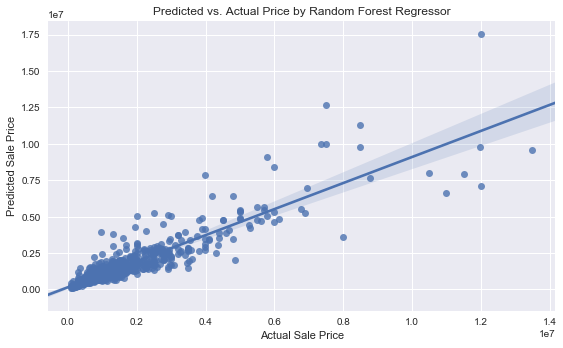

In [56]:
from sklearn.ensemble import RandomForestRegressor

#Define model and fit for RandomForestRegressor
random_forest = RandomForestRegressor()
random_forest.fit(train_X, train_y)

#training error
rf_pred = random_forest.predict(train_X)
rf_training_err = mean_absolute_error(train_y, rf_pred)

#validation error, and its prediction price
y_pred = random_forest.predict(val_X)
rf_val_error = mean_absolute_error(val_y, y_pred)

print("Random Forest Regressor error \n", 
      "Training error: ", rf_training_err,  " \n",
      "Validation error: ", rf_val_error)


plt.figure(figsize=(8, 5))
ax = sns.regplot(x = val_y, y = y_pred)
plt.title('Predicted vs. Actual Price by Random Forest Regressor')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

plt.tight_layout()

__Analysis of Error:__<br>
As we can see the Random Forest training error is much higher compared the Decision Tree's training error; however, when comparing to its own validation error, the ratio is much lower in Random Forest. And the validation error is also much lower than the Decision Tree. All these indicates that the Random Forest is a much better fit model for our data.<br><br>

__Analysis of Regression Plot:__<br>
We can see that the cluster of the price predictions below \$5 millions are much concentrated than the Decision Tree graph, it indicates less variations between the predicted and actual sale prices. Starting from \$5 millions to $7.5 millions, the prediction variation started to increase as price increases as fewer instances are available for training; however, it still performs much better than the Decision Tree.

__Summary:__ <br>
Multiple Regression gives a much lower error than simple linear regression in predicting current listings price, using this combination of features of __[Sqft, zipcode, beds, yearbuilt, baths].__ <br>

While Random Forest Regressor gives a much lower error than Decision Tree Regressor, and both training and validation errors show that it is a better fit model for predicting the future price of a new listing.
